<a href="https://colab.research.google.com/github/ngohienduong/WQU-Econ/blob/main/W5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE 610 Econometrics (C22-S1) - Groupwork Assignment Submission 2 M5

In [192]:
!pip install yfinance


### Impoting required libraries

In [193]:
import warnings
from IPython.display import Image
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.api as sm
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [194]:
warnings.filterwarnings('ignore')
%matplotlib inline
rcParams['figure.figsize'] = 20,10

### Step 0: Selecting a data set

For gold ETF, we choose SPDR Gold Trust (GLD) and for non-US equity ETF, we choose: iShares MSCI Emerging Markets ETF (EEM). We also pull data for Grayscale Bitcoin Trust (GBTC).

### Step 1: Data Importing

We consider three time points for splitting the pulled data:

In [195]:
Apr20 = dt.datetime(2020,4,1)
Jul20 = dt.datetime(2020,7,1)
Oct20 = dt.datetime(2020,10,1)
Jan21 = dt.datetime(2021,1,1)

#### Gold ETF (GLD):

In [196]:
GLD = yf.download('GLD',start = Apr20, end = Jan21,  progress = False)
GLD[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,148.199997,150.080002,147.850006,149.449997,149.449997,11827400
2020-04-02,151.199997,152.500000,150.699997,151.899994,151.899994,9188300
2020-04-03,152.229996,153.089996,151.660004,152.649994,152.649994,8469100
2020-04-06,154.160004,157.220001,153.960007,156.880005,156.880005,14739300
2020-04-07,155.330002,156.139999,154.380005,156.039993,156.039993,9195400


#### Emerging Markets ETF (EEM):

In [197]:
EEM = yf.download('EEM', start = Apr20, end = Jan21, progress = False)
EEM[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,33.099998,33.330002,32.619999,32.669998,31.540220,65580600
2020-04-02,33.290001,33.939999,33.200001,33.770000,32.602184,55784000
2020-04-03,33.689999,33.860001,32.950001,33.130001,31.984318,68672500
2020-04-06,34.439999,34.950001,34.299999,34.939999,33.731724,82394800
2020-04-07,36.090000,36.119999,35.049999,35.119999,33.905499,74322600


#### Bitcoin (BTC):

In [198]:
GBTC = yf.download('GBTC', start = Apr20, end = Jan21, progress = False)
GBTC[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,6.800,6.90,6.41,6.495,6.495,4274800
2020-04-02,7.000,7.87,6.98,7.720,7.720,7980600
2020-04-03,7.940,7.94,7.25,7.480,7.480,3059800
2020-04-06,7.824,8.06,7.71,7.950,7.950,4910400
2020-04-07,8.070,8.15,7.61,7.660,7.660,3469900


#### Integrating the data

In [199]:
data = pd.DataFrame({'EEM':EEM['Adj Close'], 'GLD':GLD['Adj Close'], 'GBTC':GBTC['Adj Close']})
data[Apr20:Jan21].head()

,EEM,GLD,GBTC
Date,,,
2020-04-01,31.540220,149.449997,6.495
2020-04-02,32.602184,151.899994,7.720
2020-04-03,31.984318,152.649994,7.480
2020-04-06,33.731724,156.880005,7.950
2020-04-07,33.905499,156.039993,7.660


In [200]:
data.isnull().any()

EEM     False
GLD     False
GBTC    False
dtype: bool

### Step 2: Data Processing

In [201]:
data['GLD_lr'] = np.log(data['GLD']).diff()
data['EEM_lr'] = np.log(data['EEM']).diff()
data['GBTC_lr'] = np.log(data['GBTC']).diff()
data['GLD_dr'] = data['GLD'].pct_change()
data['EEM_dr'] = data['EEM'].pct_change()
data['GBTC_dr'] = data['GBTC'].pct_change()
data[Apr20:Jan21].head()

,EEM,GLD,GBTC,GLD_lr,EEM_lr,GBTC_lr,GLD_dr,EEM_dr,GBTC_dr
Date,,,,,,,,,
2020-04-01,31.540220,149.449997,6.495,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-02,32.602184,151.899994,7.720,0.016261,0.033116,0.172782,0.016393,0.033670,0.188607
2020-04-03,31.984318,152.649994,7.480,0.004925,-0.019134,-0.031582,0.004937,-0.018952,-0.031088
2020-04-06,33.731724,156.880005,7.950,0.027334,0.053193,0.060939,0.027711,0.054633,0.062834
2020-04-07,33.905499,156.039993,7.660,-0.005369,0.005138,-0.037160,-0.005354,0.005152,-0.036478


### Step 3: Data Summaries

In [202]:
data['EEM_MA20'] = data['EEM'].rolling(window=20).mean()
data['GLD_MA20'] = data['GLD'].rolling(window=20).mean()
data['GBTC_MA20'] = data['GBTC'].rolling(window=20).mean()
data = data[Apr20:Jan21]
data.head()

,EEM,GLD,GBTC,GLD_lr,EEM_lr,GBTC_lr,GLD_dr,EEM_dr,GBTC_dr,EEM_MA20,GLD_MA20,GBTC_MA20
Date,,,,,,,,,,,,
2020-04-01,31.540220,149.449997,6.495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-02,32.602184,151.899994,7.720,0.016261,0.033116,0.172782,0.016393,0.033670,0.188607,NaN,NaN,NaN
2020-04-03,31.984318,152.649994,7.480,0.004925,-0.019134,-0.031582,0.004937,-0.018952,-0.031088,NaN,NaN,NaN
2020-04-06,33.731724,156.880005,7.950,0.027334,0.053193,0.060939,0.027711,0.054633,0.062834,NaN,NaN,NaN
2020-04-07,33.905499,156.039993,7.660,-0.005369,0.005138,-0.037160,-0.005354,0.005152,-0.036478,NaN,NaN,NaN


####  Compute the kurtosis for each series.

In [203]:
from scipy.stats import kurtosis
data = data.dropna()
kurtosis(np.array(data['GLD_dr']))

4.572693181033514

In [204]:
kurtosis(np.array(data['EEM_dr']))

1.578774688873903

In [205]:
kurtosis(np.array(data['GBTC_dr']))

1.9251626858565327

#### Extreme value analysis

In [206]:
!pip install pyextremes

We identify the extreme value of the series using Peaks Over Threshold (POT) method (Coles, 2001, p.79). Given an extreme threshold $\mu$ value as hyperparameter, POT clusters values higher than $\mu$ and select the highest value in each clusters as the cut off. To select the appropriate threshhold $\mu$, we follow Enders (2004) for unknown threshold selection and choose $\mu$ to be the cut off for top/ bottom 15% of the series

##### Gold Extreme Values

In [207]:
def get_threshold_range(ts):
  return np.max(ts) - (np.max(ts) - np.min(ts))*0.15, np.min(ts) + (np.max(ts) - np.min(ts))*0.15

In [208]:
get_threshold_range(data['GLD_dr'])[0]

0.012021194643233797

Higher extremes

Date
2020-05-07    0.015351
2020-06-10    0.014325
2020-07-22    0.015202
2020-07-27    0.019754
2020-08-04    0.021278
2020-08-06    0.013274
2020-08-13    0.023618
2020-08-17    0.021694
2020-08-28    0.017380
2020-10-09    0.018161
2020-11-05    0.022984
2020-12-01    0.021060
2020-12-07    0.014914
2020-12-15    0.013991
Name: GLD_dr, dtype: float64

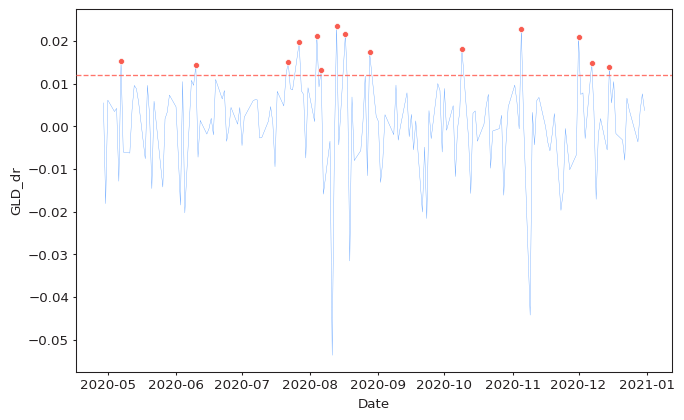

In [209]:
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
GLD_extremes_high = get_extremes(data['GLD_dr'], "POT", threshold=get_threshold_range(data['GLD_dr'])[0], r="24H")
plot_extremes(
    ts=data['GLD_dr'],
    extremes=GLD_extremes_high,
    extremes_method="POT",
    extremes_type="high",
    threshold=get_threshold_range(data['GLD_dr'])[0],
)
GLD_extremes_high

Lower extremes

Date
2020-08-11   -0.053694
2020-11-09   -0.044271
Name: GLD_dr, dtype: float64

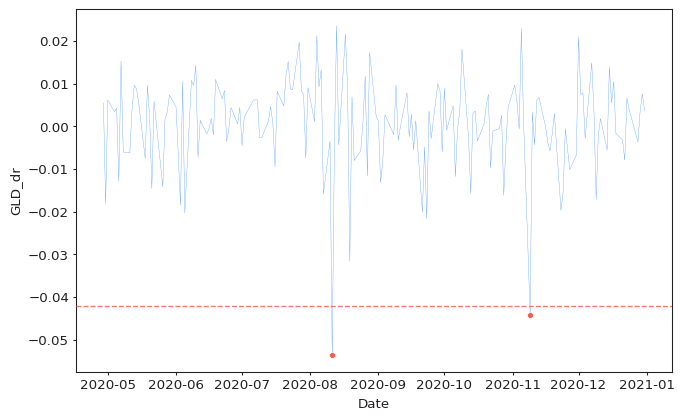

In [210]:
GLD_extremes_low = get_extremes(data['GLD_dr'], "POT", threshold=get_threshold_range(data['GLD_dr'])[1], extremes_type = "low", r="24H")
plot_extremes(
    ts=data['GLD_dr'],
    extremes=GLD_extremes_low,
    extremes_method="POT",
    extremes_type="low",
    threshold=get_threshold_range(data['GLD_dr'])[1],
)
GLD_extremes_low

##### EEM Extreme Values

Date
2020-04-29    0.029145
2020-05-18    0.039134
2020-07-06    0.043037
2020-11-04    0.031442
Name: EEM_dr, dtype: float64

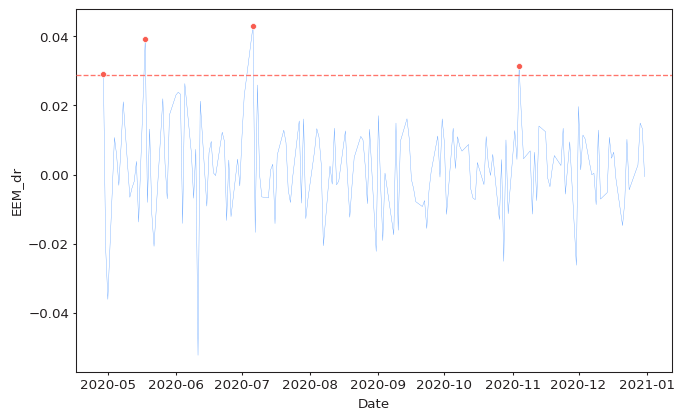

In [211]:
EEM_extremes_high = get_extremes(data['EEM_dr'], "POT", threshold=get_threshold_range(data['EEM_dr'])[0], r="24H")
plot_extremes(
    ts=data['EEM_dr'],
    extremes=EEM_extremes_high,
    extremes_method="POT",
    extremes_type="high",
    threshold=get_threshold_range(data['EEM_dr'])[0],
)
EEM_extremes_high

Date
2020-06-11   -0.052197
Name: EEM_dr, dtype: float64

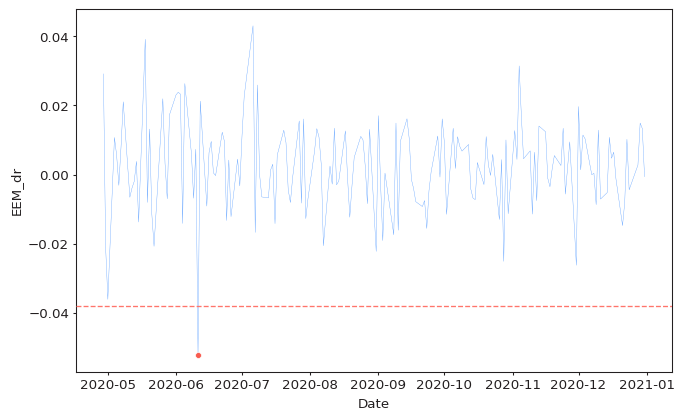

In [212]:
EEM_extremes_low = get_extremes(data['EEM_dr'], "POT", threshold=get_threshold_range(data['EEM_dr'])[1], extremes_type = "low", r="24H")
plot_extremes(
    ts=data['EEM_dr'],
    extremes=EEM_extremes_low,
    extremes_method="POT",
    extremes_type="low",
    threshold=get_threshold_range(data['EEM_dr'])[1],
)
EEM_extremes_low

GBTC Extreme Values

Date
2020-11-30    0.231431
Name: GBTC_dr, dtype: float64

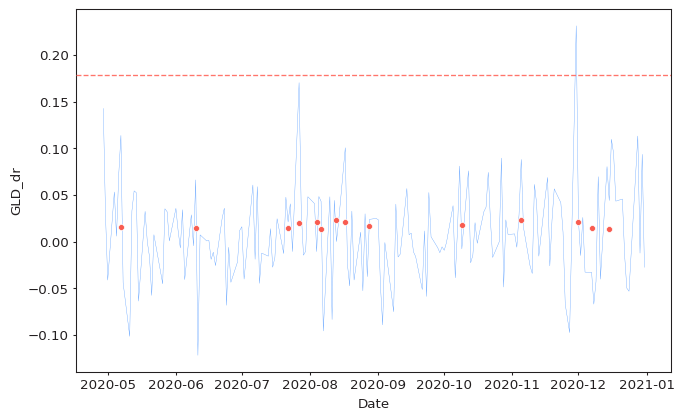

In [213]:
GBTC_extremes_high = get_extremes(data['GBTC_dr'], "POT", threshold=get_threshold_range(data['GBTC_dr'])[0], r="24H")
plot_extremes(
    ts=data['GBTC_dr'],
    extremes=GLD_extremes_high,
    extremes_method="POT",
    extremes_type="high",
    threshold=get_threshold_range(data['GBTC_dr'])[0],
)
GBTC_extremes_high

Date
2020-05-11   -0.101310
2020-06-11   -0.121594
2020-08-07   -0.095568
2020-08-11   -0.083272
2020-09-03   -0.089049
2020-09-08   -0.074938
2020-11-27   -0.097292
Name: GBTC_dr, dtype: float64

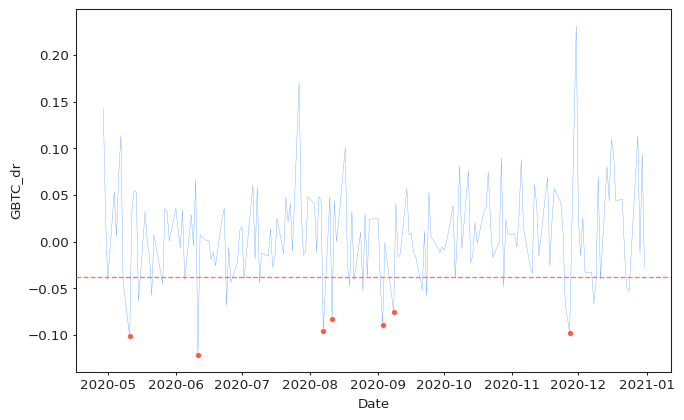

In [214]:
GBTC_extremes_low = get_extremes(data['GBTC_dr'], "POT", threshold=get_threshold_range(data['GBTC_dr'])[1], extremes_type = "low", r="24H")
plot_extremes(
    ts=data['GBTC_dr'],
    extremes=GBTC_extremes_low,
    extremes_method="POT",
    extremes_type="low",
    threshold=get_threshold_range(data['EEM_dr'])[1],
)
GBTC_extremes_low

### Step 4: Data Comparision: Copula


Compare the number of extreme values in each series

In [215]:
print("GLD extreme values count is " + str(len(GLD_extremes_high)+ len(GLD_extremes_low)))
print("EEM extreme values count is " + str(len(EEM_extremes_high)+ len(EEM_extremes_low)))
print("GBTC extreme values count is " + str(len(GBTC_extremes_high)+ len(GBTC_extremes_low)))

GLD extreme values count is 16
EEM extreme values count is 5
GBTC extreme values count is 8


Since GLD and GBTC are the two series with higher extreme value count, we plot them against each other as follow

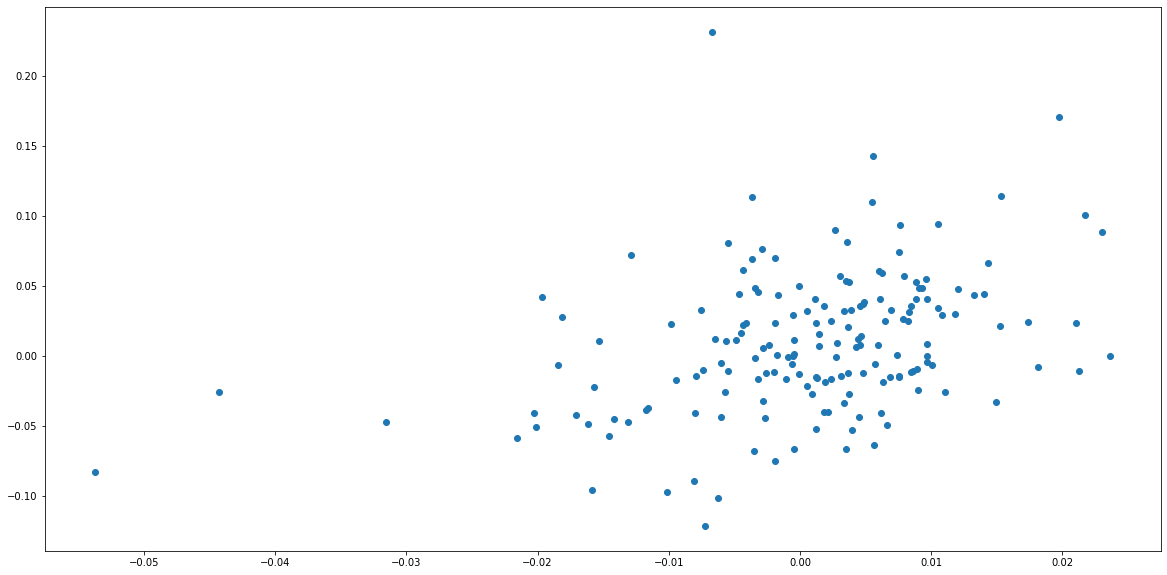

In [216]:
plt.scatter(data['GLD_dr'], data['GBTC_dr'])

We then fit the Clayton copula to the 2 series returns in the following section

In [217]:
!pip install copulae

In [218]:
from copulae.archimedean import ClaytonCopula
cc = ClaytonCopula(dim = 2)
cc.fit(data[['GLD_dr','GBTC_dr']])
cc.summary()

          GLD_dr     GBTC_dr
count  172.00000  172.000000
mean     0.50000    0.500000
std      0.28784    0.287839
min      0.00578    0.005780
25%      0.25289    0.252890
50%      0.50000    0.500000
75%      0.74711    0.747110
max      0.99422    0.994220


Clayton Copula Summary
================================================================================
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 0.5934885170157524

In [219]:
cc.log_lik(data[['GLD_dr','GBTC_dr']])

14.879658111173384

The low log likelihood value implies the fitted model of Clayton Copula with theta parameter ~ 0.59 did not fit the data very well

### Step 5: Category 1 model for GBTC

In [220]:
!pip install backtesting

In this section, we conduct ARMA/ GARCH based strategy for GBTC data

#### 1st type: ARMA-based

##### Performance evaluation of GBTC (5.2, 5.3)

In [221]:
!pip install arch

In [222]:
!pip install pmdarima

###### 1st horizon Q2, 2nd horizon Q3

In [223]:
data_q2 = data[Apr20:Jul20]
data_q3 = data[Jul20:Oct20]
data_q4 = data[Oct20:Jan21]

We do a sample ARMA parameter selection based on traditional ACF/PACF plot method here for Q2 just for pedagogical purpose. We will use pmdarima library for ARMA/ GARCH parameter selection for the rest of our implementation

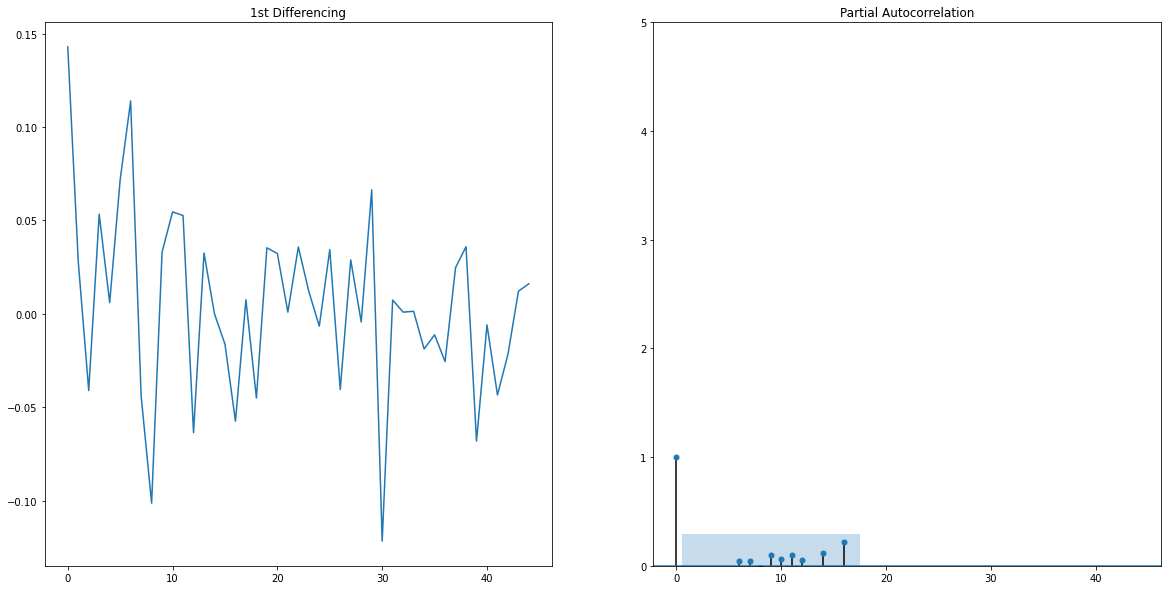

In [224]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.DataFrame(data_q2['GBTC_dr']).reset_index(drop=True)
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.diff().dropna(), ax=axes[1])

plt.show()

Based on the ACF plot, we choose 1 as the order of the AR term

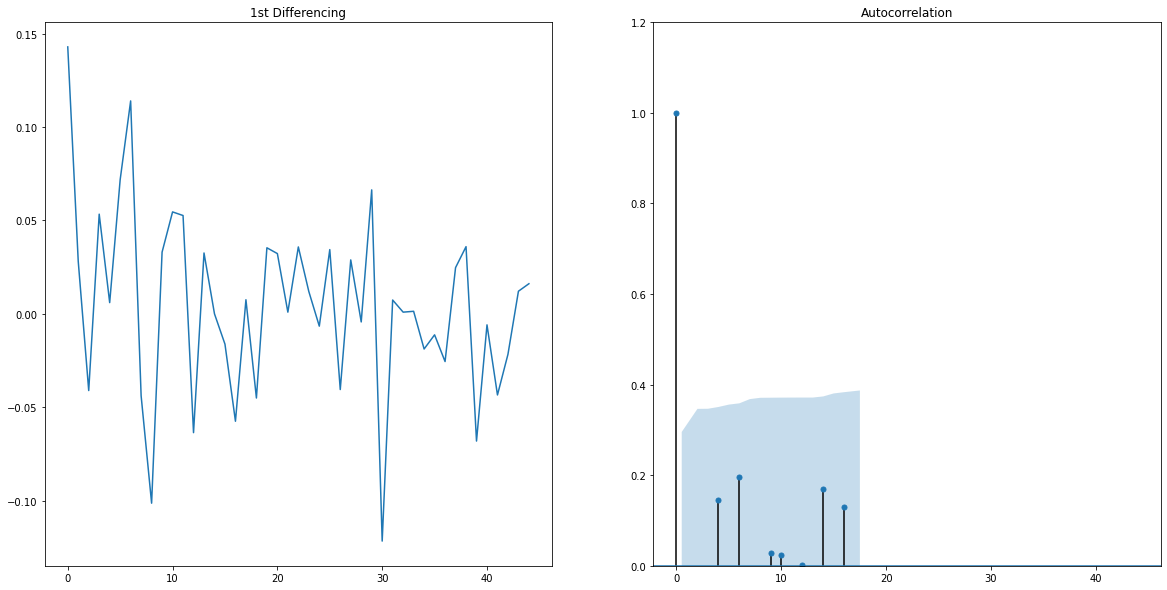

In [225]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.diff().dropna(), ax=axes[1])

plt.show()

Based on the correlation plot, we choose 1 as the MA term

In [226]:
# Forecasting
import pmdarima
def ARMA_fit_predict(fit_period, predict_period):
  arima_model_fitted = pmdarima.auto_arima(fit_period)
  return arima_model_fitted.predict(len(predict_period)), arima_model_fitted.arima_res_.resid
data_q3['GBTC_pp'] = ARMA_fit_predict(data_q2['GBTC_dr'], data_q3['GBTC_dr'])[0]

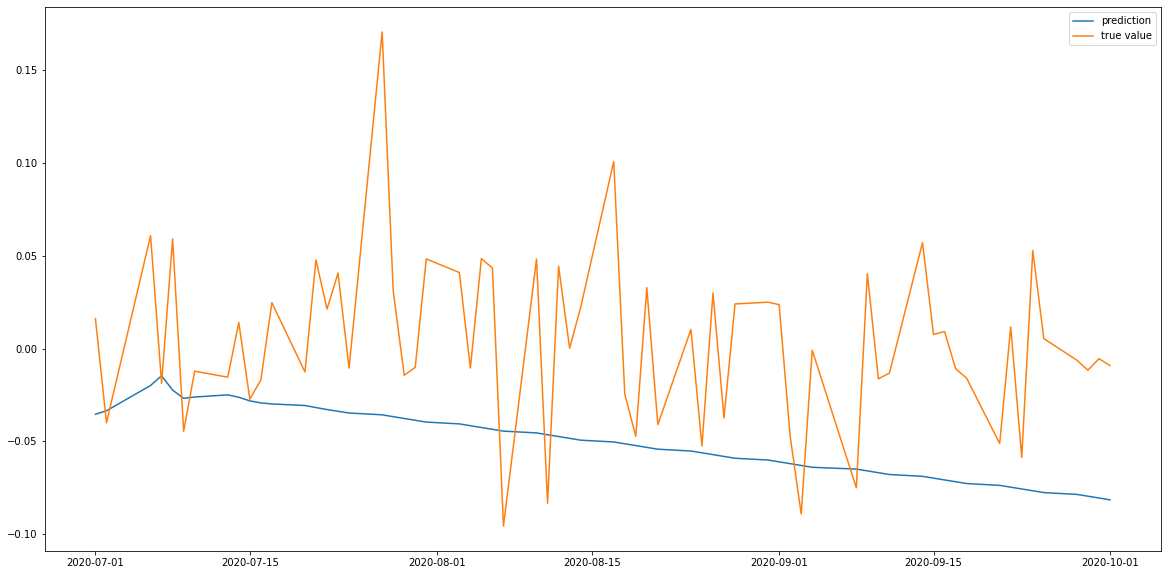

In [227]:
plt.plot(data_q3['GBTC_pp'], label = 'prediction')
plt.plot(data_q3['GBTC_dr'], label = 'true value')
plt.legend()

###### 1st horizon Q3, 2nd horizon Q4

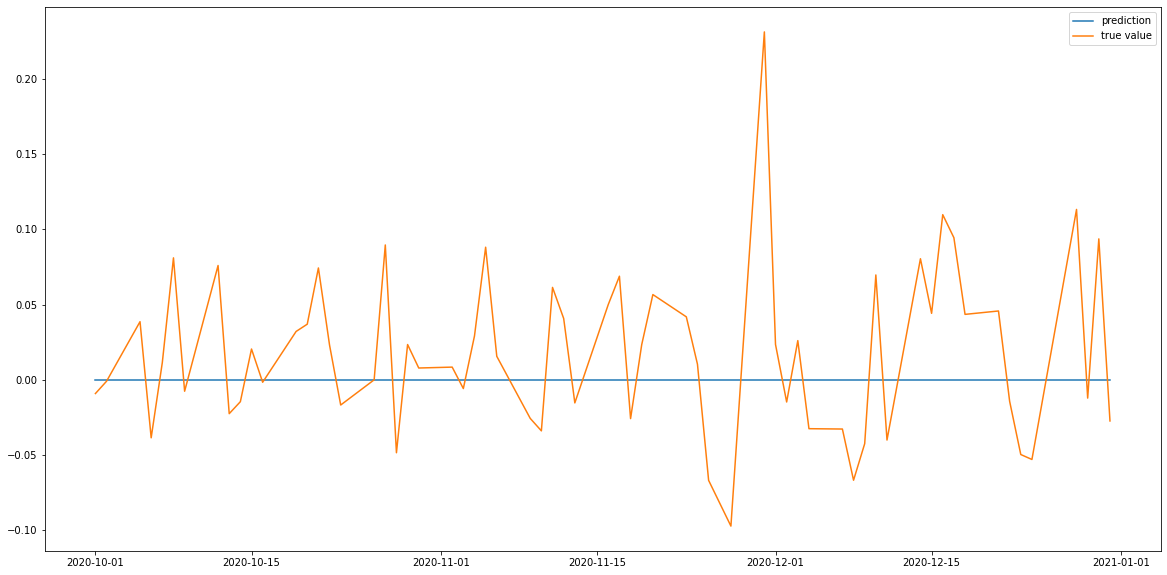

In [228]:
data_q4['GBTC_pp'] = ARMA_fit_predict(data_q3['GBTC_dr'], data_q4['GBTC_dr'])[0]
plt.plot(data_q4['GBTC_pp'], label = 'prediction')
plt.plot(data_q4['GBTC_dr'], label = 'true value')
plt.legend()

##### ARMA trading strategy

Our ARMA strategy is described as follow

*   Train ARMA models over all previous returns (a testing period for 172 days means 171 models)
*   Using ARMA models to predict next day returns
*   If the predicted returns for next day is negative, short the stock. If postive, long the stock
*   To make sure the model has enough training data, we test our method only on Q3 and Q4 data




In [371]:
data_q3_q4 = data[Jul20:Jan21]
data_q3_q4['GBTC_pp_a'] = [ARMA_fit_predict(data['GBTC_dr'].iloc[0:i-1], data['GBTC_dr'].iloc[i-1:i])[0] for i in range(len(data_q2) -1, len(data))]

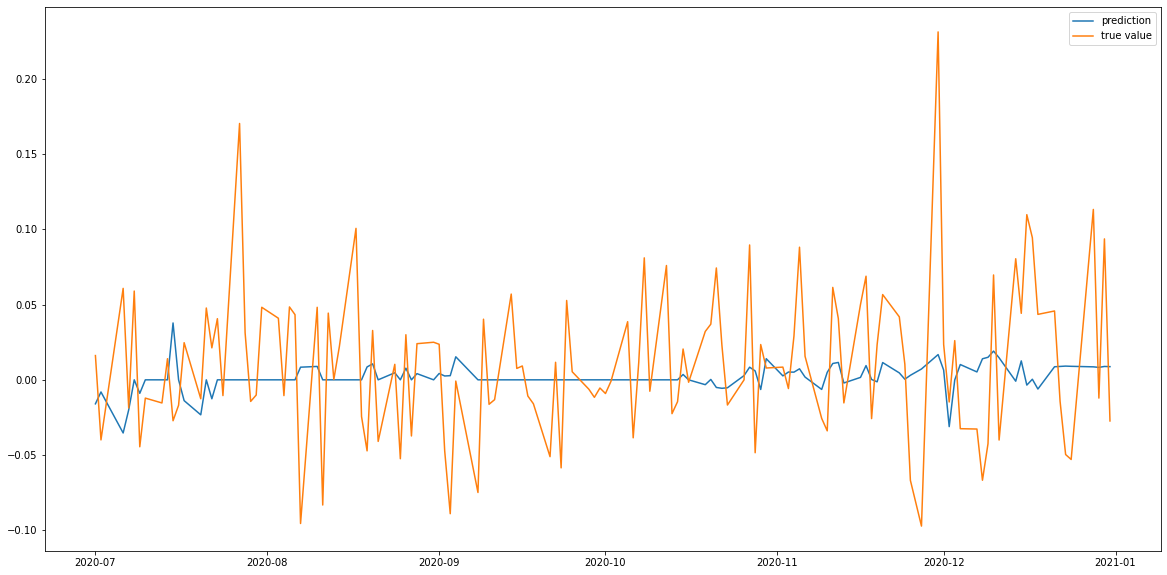

In [372]:
plt.plot(data_q3_q4['GBTC_pp_a'], label = 'prediction')
plt.plot(data_q3_q4['GBTC_dr'], label = 'true value')
plt.legend()

In [373]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, SignalStrategy
class ARMAS(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data_q3_q4['GBTC_pp_a'].apply(lambda x: x/abs(x)))
bt = Backtest(GBTC[Jul20:Jan21], ARMAS, exclusive_orders=False)
stats = bt.run()
bt.plot()

Row(id='22618', ...)

In [309]:
stats

Start                     2020-07-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    183 days 00:00:00
Exposure Time [%]                    97.65625
Equity Final [$]                 10333.000051
Equity Peak [$]                  10353.040048
Return [%]                           3.330001
Buy & Hold Return [%]              227.868845
Return (Ann.) [%]                    6.661647
Volatility (Ann.) [%]                 3.04788
Sharpe Ratio                         2.185666
Sortino Ratio                         5.23398
Calmar Ratio                         7.430113
Max. Drawdown [%]                   -0.896574
Avg. Drawdown [%]                   -0.294256
Max. Drawdown Duration      112 days 00:00:00
Avg. Drawdown Duration       17 days 00:00:00
# Trades                                   51
Win Rate [%]                        82.352941
Best Trade [%]                      92.477622
Worst Trade [%]                    -46.868474
Avg. Trade [%]                    

####2nd type: GARCH based
Previous introduced ARMA based trading strategy relies on the predicted conditional mean from ARMA (Equation 1)

$$ y_t = \mu +\sum_{i=1}^p a_iy_{t-i} +\sum_{i=1}^q b_i\epsilon_{t-i} + \epsilon_t(1)$$

However, a fundamental assumption in ARMA is that the time series has constant variance $Var(y) = c$, which is not always met in practice. Here, we adopt GARCH model to model the conditional variance of the ARMA error term $\epsilon_t$, denoted ARMA-GARCH approach

##### Performance evaluation of GBTC (5.2, 5.3)

###### 1st horizon Q2, 2nd horizon Q3

In [233]:
# Forecasting
import pmdarima
def ARMA_GARCH_fit_predict(fit_period, predict_period):
  ar = ARMA_fit_predict(fit_period, predict_period)[0]
  arima_residuals = ARMA_fit_predict(fit_period, predict_period)[1]
  garch = arch.arch_model(arima_residuals, p=1, q=1)
  garch_fitted = garch.fit()
  ga = garch_fitted.forecast(horizon = len(predict_period)).mean.iloc[-1]
  return ar + ga
data_q3['GBTC_pp_g'] = np.array(ARMA_GARCH_fit_predict(data_q2['GBTC_dr'], data_q3['GBTC_dr']))

Iteration:      1,   Func. Count:      6,   Neg. LLF: -71.685083002464
Iteration:      2,   Func. Count:     17,   Neg. LLF: -71.89308022444419
Iteration:      3,   Func. Count:     25,   Neg. LLF: -72.24670380026416
Iteration:      4,   Func. Count:     33,   Neg. LLF: -72.2548409092665
Iteration:      5,   Func. Count:     40,   Neg. LLF: -72.29891685600681
Iteration:      6,   Func. Count:     47,   Neg. LLF: -72.34574948617887
Iteration:      7,   Func. Count:     54,   Neg. LLF: -72.39361306728556
Iteration:      8,   Func. Count:     61,   Neg. LLF: -72.44142941399463
Iteration:      9,   Func. Count:     68,   Neg. LLF: -72.48822446819119
Iteration:     10,   Func. Count:     75,   Neg. LLF: -72.67796836587323
Iteration:     11,   Func. Count:     84,   Neg. LLF: -72.67804937998203
Iteration:     12,   Func. Count:     95,   Neg. LLF: -72.69276899339042
Iteration:     13,   Func. Count:    105,   Neg. LLF: -72.69880852789177
Iteration:     14,   Func. Count:    111,   Neg. LLF: 

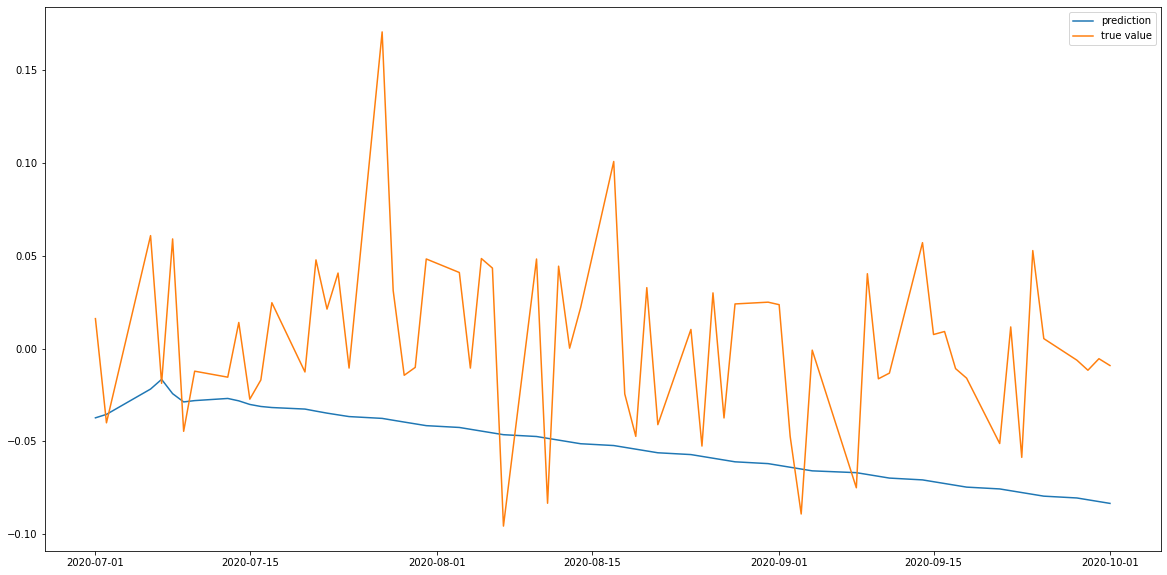

In [234]:
plt.plot(data_q3['GBTC_pp_g'], label = 'prediction')
plt.plot(data_q3['GBTC_dr'], label = 'true value')
plt.legend()

###### 1nd horizon Q3, 2nd horizon Q4

In [235]:
data_q4['GBTC_pp_g'] = np.array(ARMA_GARCH_fit_predict(data_q3['GBTC_dr'], data_q4['GBTC_dr']))

Iteration:      1,   Func. Count:      6,   Neg. LLF: -109.41718716882764
Iteration:      2,   Func. Count:     16,   Neg. LLF: -109.41785629922958
Iteration:      3,   Func. Count:     25,   Neg. LLF: -109.41932190344659
Iteration:      4,   Func. Count:     31,   Neg. LLF: -109.53924100749099
Iteration:      5,   Func. Count:     37,   Neg. LLF: -109.53957608378832
Iteration:      6,   Func. Count:     43,   Neg. LLF: -109.53994776136881
Iteration:      7,   Func. Count:     49,   Neg. LLF: -109.53998969489176
Iteration:      8,   Func. Count:     55,   Neg. LLF: -109.54025190515162
Iteration:      9,   Func. Count:     62,   Neg. LLF: -109.54108315089233
Iteration:     10,   Func. Count:     69,   Neg. LLF: -109.5412732888181
Iteration:     11,   Func. Count:     76,   Neg. LLF: -109.54148534477766
Iteration:     12,   Func. Count:     83,   Neg. LLF: -109.5417070379947
Iteration:     13,   Func. Count:     90,   Neg. LLF: -109.54194249965545
Iteration:     14,   Func. Count:     97

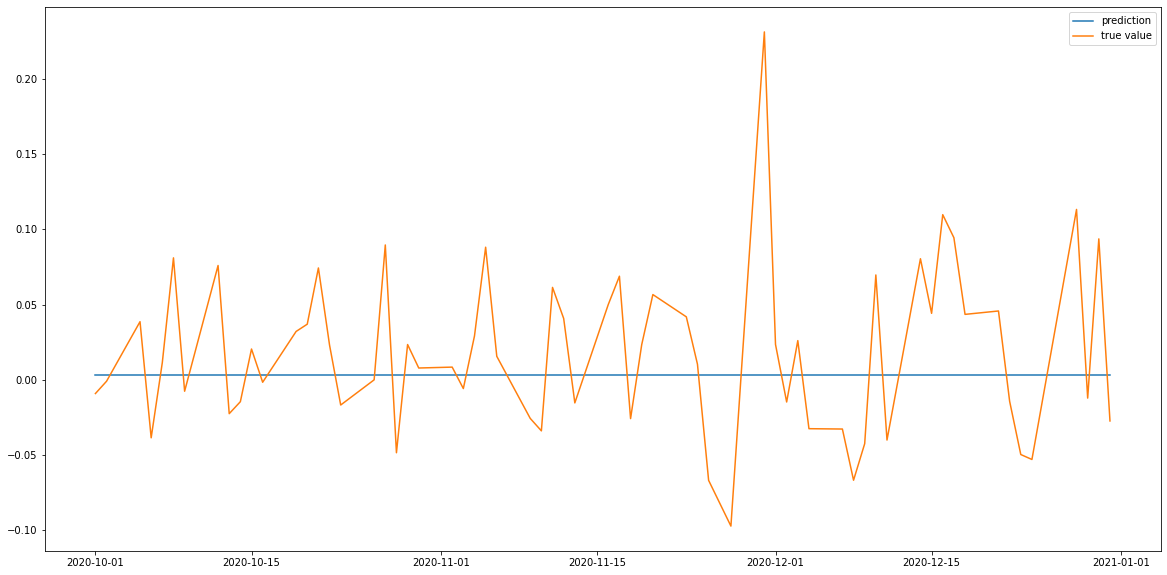

In [236]:
plt.plot(data_q4['GBTC_pp_g'], label = 'prediction')
plt.plot(data_q4['GBTC_dr'], label = 'true value')
plt.legend()

##### GARCH trading strategy

Our ARMA strategy is described as follow

*   Train ARMA-GARCH models over all previous returns (a testing period for 172 days means 171 models)
*   Using ARMA-GARCH models to predict next day returns
*   If the predicted returns for next day is negative, short the stock. If postive, long the stock
*   To make sure the model has enough training data, we test our method only on Q3 and Q4 data



In [374]:
%%capture
data_q3_q4['GBTC_pp_g'] = [ARMA_GARCH_fit_predict(data['GBTC_dr'].iloc[0:i-1], data['GBTC_dr'].iloc[i-1:i])[0] for i in range(len(data_q2) -1, len(data))]

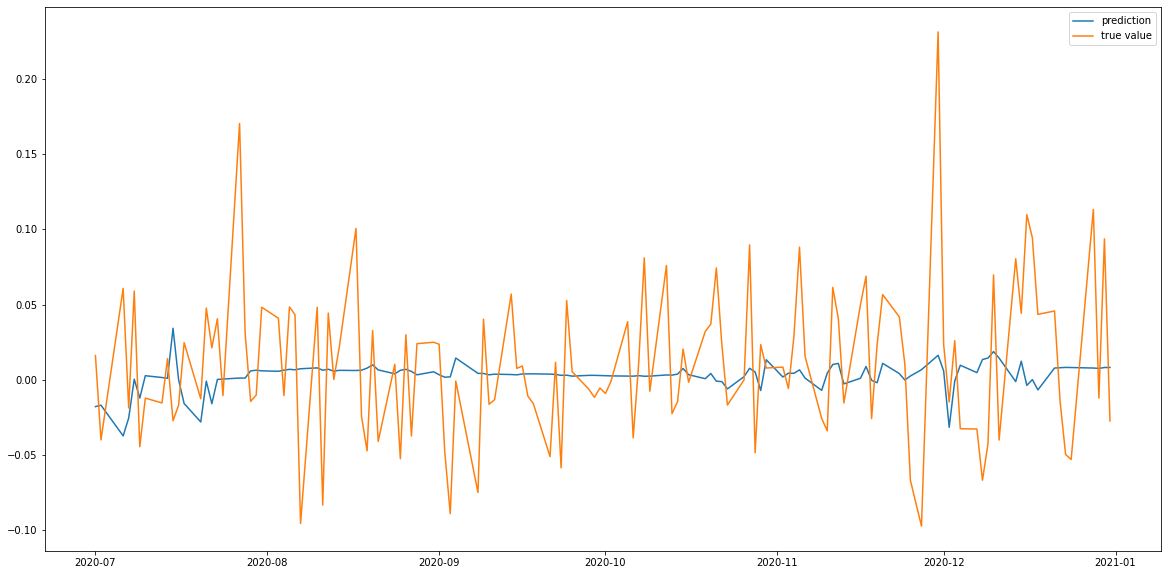

In [375]:
plt.plot(data_q3_q4['GBTC_pp_g'], label = 'prediction')
plt.plot(data_q3_q4['GBTC_dr'], label = 'true value')
plt.legend()

In [376]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, SignalStrategy

class GARCH(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data_q3_q4['GBTC_pp_g'].apply(lambda x: x/abs(x)))
bt = Backtest(GBTC[Jul20:Jan21], GARCH, exclusive_orders=False)
stats = bt.run()
bt.plot()

Row(id='23414', ...)

In [240]:
stats

Start                     2020-07-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    183 days 00:00:00
Exposure Time [%]                     98.4375
Equity Final [$]                 11775.030231
Equity Peak [$]                  11862.870215
Return [%]                          17.750302
Buy & Hold Return [%]              227.868845
Return (Ann.) [%]                    37.94517
Volatility (Ann.) [%]               19.746298
Sharpe Ratio                         1.921635
Sortino Ratio                        5.440575
Calmar Ratio                         8.053185
Max. Drawdown [%]                   -4.711821
Avg. Drawdown [%]                   -1.625619
Max. Drawdown Duration      112 days 00:00:00
Avg. Drawdown Duration       15 days 00:00:00
# Trades                                  102
Win Rate [%]                        65.686275
Best Trade [%]                     205.014216
Worst Trade [%]                    -52.795036
Avg. Trade [%]                    

Based on the model statistics, it is the case that GARCH outperforms ARMA in percentage return and Calmar ratio, but underperforms by Sharpe metric by a small percentage. However, given the small sample size, Calmar ratio is more accurate than Sharpe ratio (Bacon, 2012), which suggest GARCH is the superior model

### Step 6: Category 2 model for GLD and GBTC

#### 1st type: VAR-based

##### Performance evaluation of GLD and GBTC modeling (6.2, 6.3)

###### 1st horizon Q2, 2nd horizon Q3

In [241]:
from statsmodels.tsa.api import VAR
modelQ2 = VAR(data_q2[['GBTC_dr', 'GLD_dr']])
x= modelQ2.select_order()
x.summary()

,AIC,BIC,FPE,HQIC
0,-16.18*,-16.09*,9.370e-08*,-16.15*
1,-16.08,-15.81,1.042e-07,-15.99
2,-15.89,-15.45,1.261e-07,-15.74
3,-15.84,-15.22,1.336e-07,-15.62
4,-15.74,-14.94,1.498e-07,-15.46
5,-15.65,-14.67,1.666e-07,-15.31
6,-15.60,-14.44,1.813e-07,-15.20
7,-15.43,-14.09,2.250e-07,-14.97
8,-15.32,-13.81,2.656e-07,-14.80
9,-15.19,-13.51,3.273e-07,-14.61


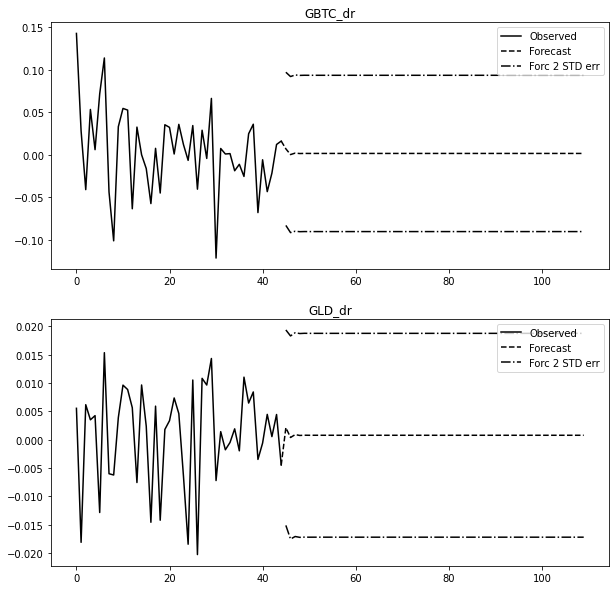

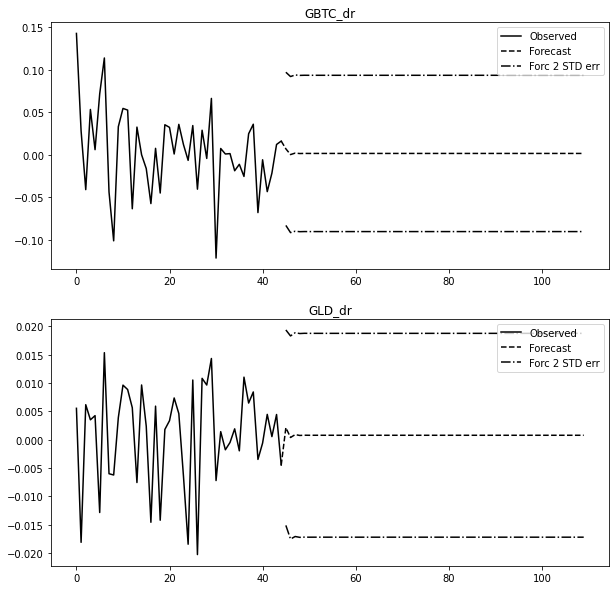

In [293]:
modelQ2_VAR = modelQ2.fit(1)
modelQ2_VAR.plot_forecast(steps=len(data_q3), plot_stderr= True)

###### 1st horizon Q3, 2nd horizon Q4

In [243]:
modelQ3 = VAR(data_q3[['GBTC_dr', 'GLD_dr']])
x= modelQ3.select_order()
x.summary()

,AIC,BIC,FPE,HQIC
0,-15.20*,-15.13*,2.495e-07*,-15.18*
1,-15.12,-14.90,2.706e-07,-15.04
2,-15.05,-14.69,2.901e-07,-14.91
3,-14.93,-14.41,3.305e-07,-14.73
4,-14.91,-14.25,3.359e-07,-14.66
5,-14.80,-13.99,3.779e-07,-14.49
6,-14.86,-13.91,3.574e-07,-14.49
7,-14.80,-13.70,3.832e-07,-14.38
8,-14.68,-13.43,4.390e-07,-14.20
9,-14.56,-13.16,5.079e-07,-14.02


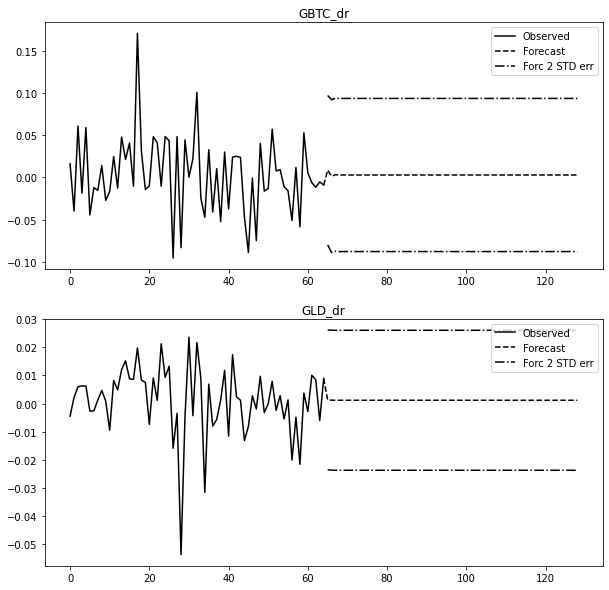

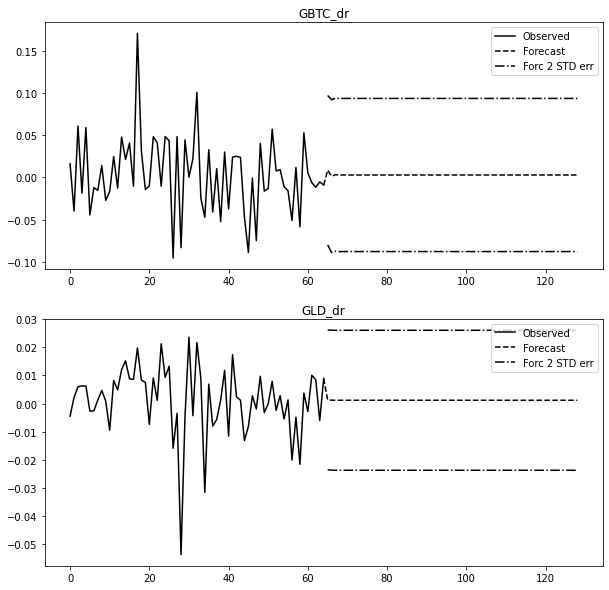

In [244]:
modelQ3_VAR = modelQ3.fit()
modelQ3_VAR.plot_forecast(steps=len(data_q4), plot_stderr= True)

Obviously, we note that training data for Q2 to predict Q3/ Q3 to predict Q4 doesn't have good performance due to small sample size

##### VAR trading strategy

Our VAR strategy is described as follow

*   Train VAR models over all previous returns on both GBTC and GLD (a testing period for 172 days means 171 models)
*   Using VAR to predict next day returns of GBTC and GLD ($r_{1}$ and $r_{2}$)
*   If the predicted returns for asset $\alpha$ next day is negative and significantly different from 0, short the stock with $\frac{\mid r_{\alpha} \mid}{\mid r_1 \mid + \mid r_2 \mid}$ of the portfolio. If postive and significantly different from 0, long the stock with the same ratio
*   To make sure the model has enough training data, we test our method only on Q3 and Q4 data



In [246]:
!pip install git+https://github.com/RJT1990/pyflux

  Cloning https://github.com/RJT1990/pyflux to /tmp/pip-req-build-3n0t7wnc
  Running command git clone -q https://github.com/RJT1990/pyflux /tmp/pip-req-build-3n0t7wnc


In [247]:
import pyflux as pf
from statsmodels.tsa.api import VAR
#Select lag order based on Q2 data only
def VAR_select_order(array):
    lag_aic = VAR(array).select_order(15).ics['aic']
    return lag_aic.index(min(lag_aic))
def VAR_fit_predict(fit_period, lag_selection_period):
    model = pf.VAR(data=fit_period, lags = VAR_select_order(lag_selection_period))
    x = model.fit()
    return [np.array(model.predict(1))[0][i] for i in range(fit_period.count(axis =1)[0])]

In [248]:
data_q3_q4['GLD_pp_v'] = [VAR_fit_predict(data[['GBTC_dr', 'GLD_dr']].iloc[0:i-1], data_q2[['GBTC_dr', 'GLD_dr']])[1] for i in range(len(data_q2) -1, len(data))]

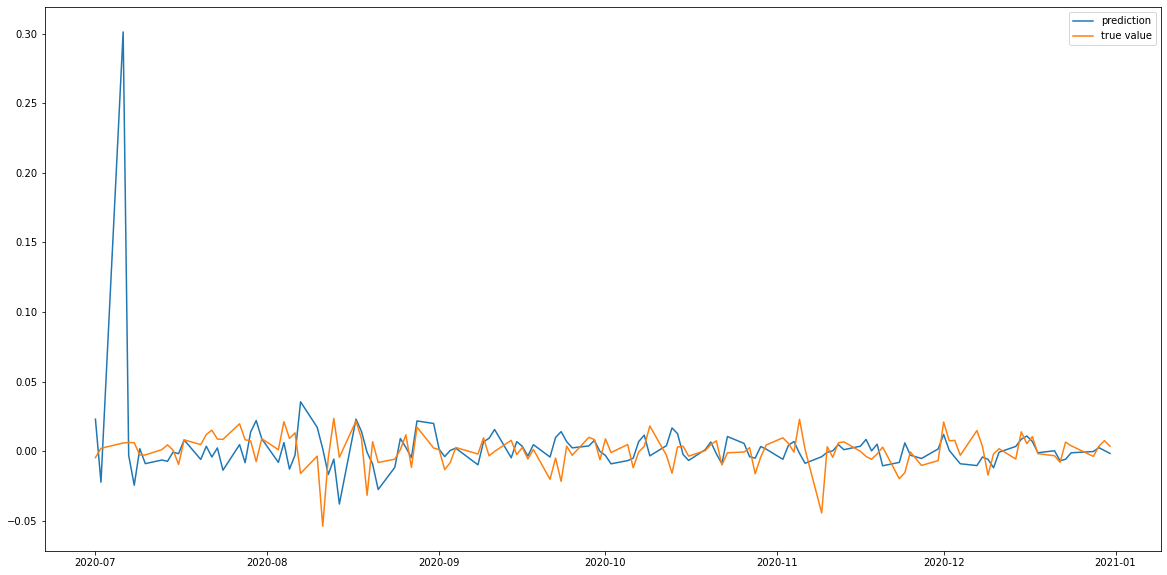

In [250]:
plt.plot(data_q3_q4['GLD_pp_v'], label = 'prediction')
plt.plot(data_q3_q4['GLD_dr'], label = 'true value')
plt.legend()

In [377]:
data_q3_q4['GBTC_pp_v'] = [VAR_fit_predict(data[['GBTC_dr', 'GLD_dr']].iloc[0:i-1], data_q2[['GBTC_dr', 'GLD_dr']])[0] for i in range(len(data_q2) -1, len(data))]

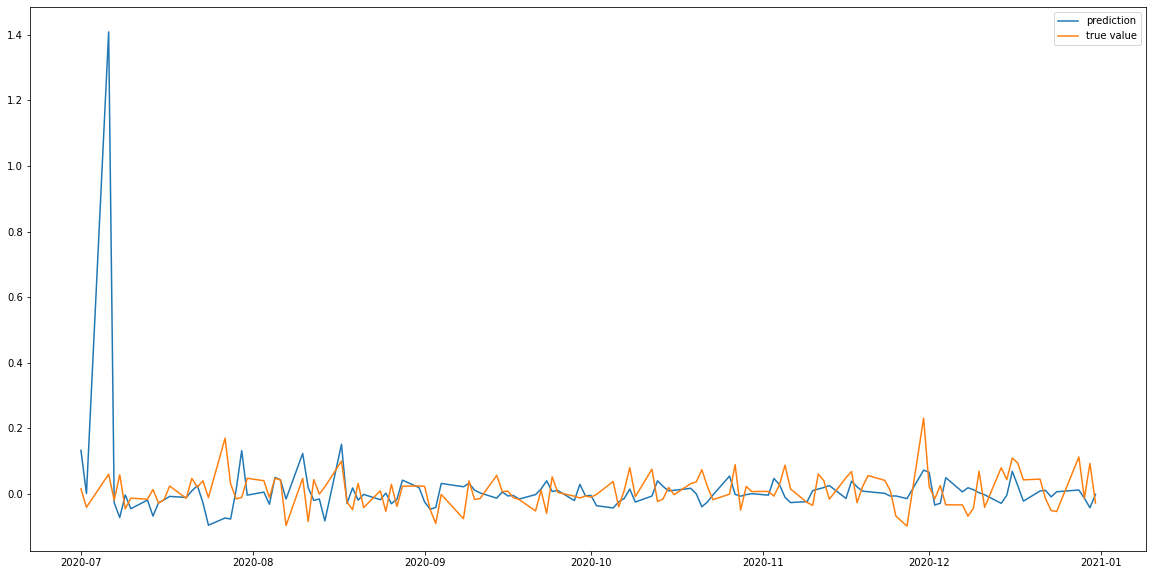

In [378]:
plt.plot(data_q3_q4['GBTC_pp_v'], label = 'prediction')
plt.plot(data_q3_q4['GBTC_dr'], label = 'true value')
plt.legend()

In [253]:
def po_allocation(GLD_return, GBTC_return):
    gld = abs(GLD_return)/(abs(GLD_return)+abs(GBTC_return))
    gbtc = abs(GBTC_return)/(abs(GLD_return)+abs(GBTC_return))
    return gld*abs(GLD_return)/GLD_return, gbtc*abs(GBTC_return)/GBTC_return
po_allocation(data_q3_q4['GLD_pp_v'], data_q3_q4['GBTC_pp_v'])[0]

Date
2020-07-01    0.147379
2020-07-02   -0.920497
2020-07-06    0.176228
2020-07-07   -0.100742
2020-07-08   -0.254913
                ...   
2020-12-24   -0.127768
2020-12-28   -0.011468
2020-12-29    0.176219
2020-12-30    0.013470
2020-12-31   -0.648656
Length: 128, dtype: float64

In [259]:
class VAR_GLD(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(po_allocation(data_q3_q4['GLD_pp_v'], data_q3_q4['GBTC_pp_v'])[0])
bt = Backtest(GLD[Jul20:Jan21], VAR_GLD, exclusive_orders=True)
stats = bt.run()
bt.plot()

Row(id='11024', ...)

In [260]:
stats

Start                     2020-07-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    183 days 00:00:00
Exposure Time [%]                     98.4375
Equity Final [$]                  10117.25412
Equity Peak [$]                  10172.399429
Return [%]                           1.172541
Buy & Hold Return [%]                7.045976
Return (Ann.) [%]                     2.32155
Volatility (Ann.) [%]                7.069984
Sharpe Ratio                         0.328367
Sortino Ratio                        0.439232
Calmar Ratio                         0.343088
Max. Drawdown [%]                   -6.766636
Avg. Drawdown [%]                   -1.245251
Max. Drawdown Duration      150 days 00:00:00
Avg. Drawdown Duration       29 days 00:00:00
# Trades                                  121
Win Rate [%]                        54.545455
Best Trade [%]                       3.805887
Worst Trade [%]                      -3.99058
Avg. Trade [%]                    

In [261]:
class VAR_GBTC(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(po_allocation(data_q3_q4['GLD_pp_v'], data_q3_q4['GBTC_pp_v'])[1])
bt = Backtest(GBTC[Jul20:Jan21], VAR_GBTC, exclusive_orders=True)
stats = bt.run()
bt.plot()

Row(id='11821', ...)

In [262]:
stats

Start                     2020-07-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    183 days 00:00:00
Exposure Time [%]                     98.4375
Equity Final [$]                  9101.648343
Equity Peak [$]                  17379.504157
Return [%]                          -8.983517
Buy & Hold Return [%]              227.868845
Return (Ann.) [%]                  -16.915961
Volatility (Ann.) [%]               58.345131
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -48.69193
Avg. Drawdown [%]                    -9.02974
Max. Drawdown Duration       60 days 00:00:00
Avg. Drawdown Duration       15 days 00:00:00
# Trades                                  126
Win Rate [%]                        56.349206
Best Trade [%]                      17.188899
Worst Trade [%]                    -20.540536
Avg. Trade [%]                    

#### 2nd type: Multi-variate GARCH based

##### GARCH Trading Strategy

A limitation of the previous trading strategy based on VAR forecast was the fact that it increases risk to the portfolio without consideration of the assets variance. To improve previously introduced strategy for 2 assets GLD and GBTC, we model the conditional variance for each assets using DCC- GARCH and exit our position when the short term variance is high - which we choose the cut off to be 0.01

In [263]:
!pip install mgarch

  Created wheel for mgarch: filename=mgarch-0.2.0-py3-none-any.whl size=3379 sha256=5669ed9d6de9862f47e84709add6cca00c9e13bc683b098190311076d52caa98
  Stored in directory: /root/.cache/pip/wheels/70/04/0f/902fe872c7729649f8aa41c1e07c685085fdfdc5ddc6407d7d
Successfully built mgarch


In [270]:
import mgarch
vol = mgarch.mgarch()
vol.fit(data_q2[['GBTC_lr', 'GLD_lr']])
vol = vol.predict(ndays = len(data_q3_q4)).alpha

In [275]:
GLD_vol = vol.iloc[:0]
GBTC_vol = vol.iloc[:1]
class DCGARCH_GLD(SignalStrategy):
    def init(self):
        super().init() 
        self.set_signal(po_allocation(data_q3_q4['GLD_pp_g'], data_q3_q4['GBTC_pp'])[0], GLD_vol > 0.01)
bt = Backtest(GLD[Jul20:Jan21], DCGARCH_GLD, exclusive_orders=True)
stats = bt.run()
bt.plot()

Row(id='13413', ...)

In [276]:
stats

Start                     2020-07-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    183 days 00:00:00
Exposure Time [%]                    92.96875
Equity Final [$]                  9662.610291
Equity Peak [$]                  10035.580032
Return [%]                          -3.373897
Buy & Hold Return [%]                7.045976
Return (Ann.) [%]                    -6.53377
Volatility (Ann.) [%]                 3.73617
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -3.765199
Avg. Drawdown [%]                   -0.962295
Max. Drawdown Duration      147 days 00:00:00
Avg. Drawdown Duration       43 days 00:00:00
# Trades                                  115
Win Rate [%]                        51.304348
Best Trade [%]                       3.254131
Worst Trade [%]                      -3.99058
Avg. Trade [%]                    

In [281]:
class DCGARCH_GBTC(SignalStrategy):
    def init(self):
        super().init() 
        self.set_signal(po_allocation(data_q3_q4['GLD_pp_g'], data_q3_q4['GBTC_pp'])[0], GBTC_vol > 0.01)
bt = Backtest(GBTC[Jul20:Jan21], DCGARCH_GBTC, exclusive_orders=True)
stats = bt.run()
bt.plot()

Row(id='15801', ...)

In [282]:
stats

Start                     2020-07-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    183 days 00:00:00
Exposure Time [%]                     98.4375
Equity Final [$]                 10296.380161
Equity Peak [$]                  10572.840046
Return [%]                           2.963802
Buy & Hold Return [%]              227.868845
Return (Ann.) [%]                    5.918725
Volatility (Ann.) [%]               13.083203
Sharpe Ratio                         0.452391
Sortino Ratio                        0.622772
Calmar Ratio                         0.806734
Max. Drawdown [%]                   -7.336652
Avg. Drawdown [%]                   -2.473974
Max. Drawdown Duration      106 days 00:00:00
Avg. Drawdown Duration       29 days 00:00:00
# Trades                                  125
Win Rate [%]                             53.6
Best Trade [%]                      20.540536
Worst Trade [%]                    -17.188899
Avg. Trade [%]                    

The result shows that the VAR + multi-variate GARCH approach showed minor improvements compared to the VAR approach

#### 3rd type: Cointegration based 

We first analyze the co-integration relationship between GLD and EEM using the Engle Granger approach. First, we test if a trend component exist in the data

In [283]:
from statsmodels.formula.api import ols
def trend_test(time_series):
  x = np.stack((time_series, range(len(time_series))), axis =1)
  x = pd.DataFrame(x, columns = ('s', 't'))
  formula = 's ~ t'
  return ols(formula, x).fit().t_test('t = 0')

In [284]:
trend_test(data['GLD'])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0905      0.011      8.319      0.000       0.069       0.112

In [285]:
trend_test(data['GBTC'])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0855      0.005     16.329      0.000       0.075       0.096

The trend test with low p value suggested that we should use no trend ADF test to check for existance of unit root

In [287]:
from arch.unitroot import ADF
ADF(data['GLD'], trend = "n")

Test Statistic,0.571
P-value,0.841
Lags,0


In [288]:
ADF(data['GBTC'], trend = "n")

Test Statistic,2.451
P-value,0.998
Lags,0


Since the ADF for GLD and GBTC suggest they are I(1), we can proceed to cointegration analysis by testing the hypothesis that the coefficient of the dependent time series is stationary (the second step of Engle Granger method)

In [290]:
from statsmodels.tsa.stattools import coint as ct
def eg_test(eq1, eq2):
    print(f'the t-statistic is: {ct(eq1, eq2)[0]}, the p-value is: {ct(eq1, eq2)[1]}, and the critical value at 5% test statistic is {ct(eq1, eq2)[2][1]}')
eg_test(data['GLD'],data['GBTC'])

the t-statistic is: -1.7848659962053857, the p-value is: 0.6370436952986417, and the critical value at 5% test statistic is -3.3720949157005573


Given the large p value, we fail to reject the hypothesis that there is no cointegration relationship between the time series. Thus base on the Engle-Granger test result, we should not use GLD as a predictor for GBTC

In [291]:
eg_test(data['GBTC'],data['GLD'])

the t-statistic is: 1.5679397586221997, the p-value is: 1.0, and the critical value at 5% test statistic is -3.3720949157005573


Given the large p value, we fail to reject the hypothesis that there is no cointegration relationship between the time series. Thus base on the Engle-Granger test result, we should not use GBTC as a predictor for GLD

From the cointegration test result, we don't recommend implementing a pair trading strategy

### Step 7: Category 3 model for GLD, EEM, and GBTC

#### 1st type: VAR-based

##### Performance evaluation of GLD, EEM, and GBTC modeling (7.2, 7.3)

###### 1st horizon Q2, 2nd horizon Q3

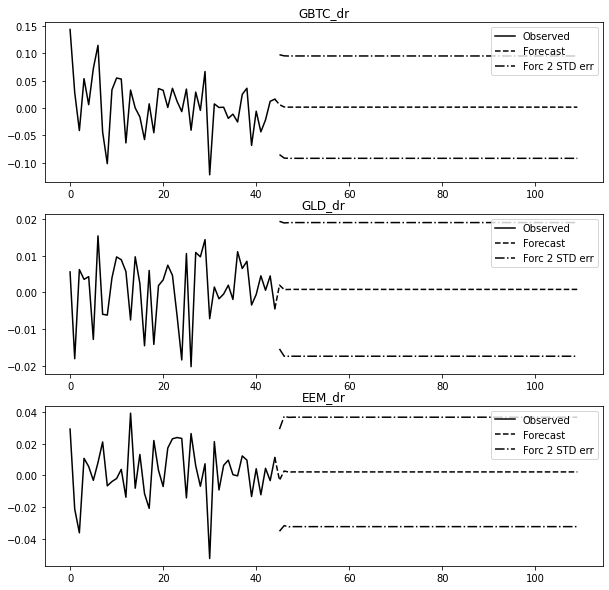

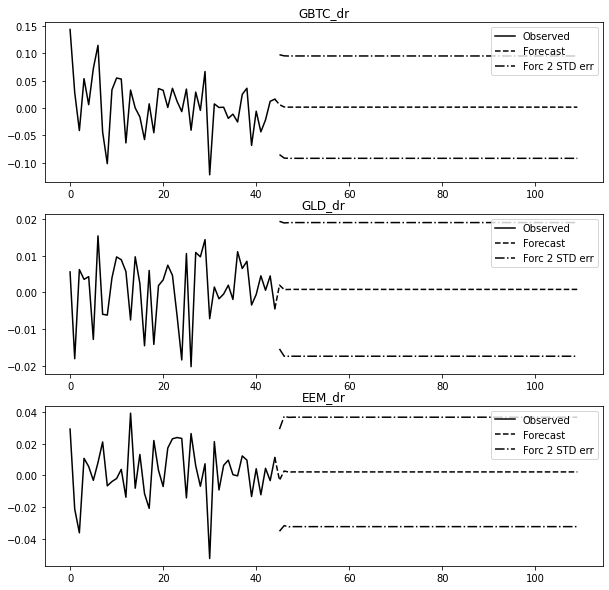

In [300]:
modelQ2 = VAR(data_q2[['GBTC_dr', 'GLD_dr', 'EEM_dr']])
modelQ2_VAR = modelQ2.fit(1)
modelQ2_VAR.plot_forecast(steps=len(data_q3), plot_stderr= True)

###### 1st horizon Q3, 2nd horizon Q4

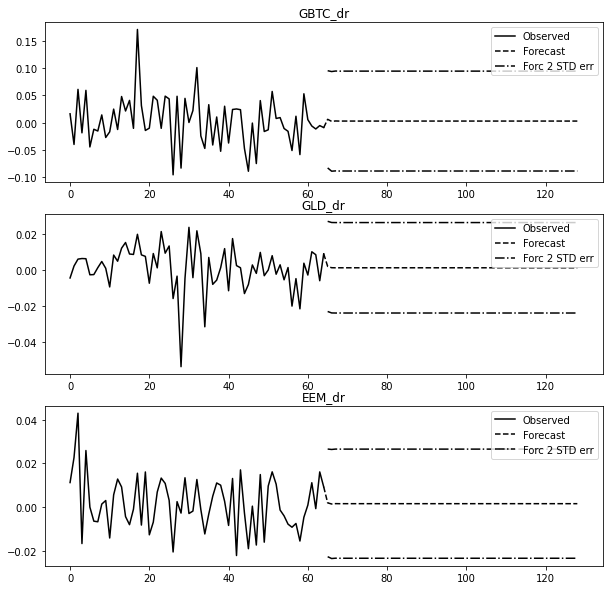

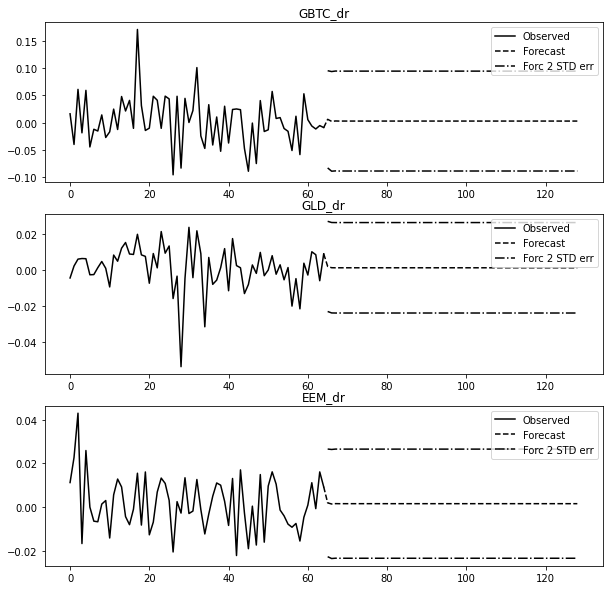

In [301]:
modelQ3 = VAR(data_q3[['GBTC_dr', 'GLD_dr', 'EEM_dr']])
modelQ3_VAR = modelQ3.fit(1)
modelQ3_VAR.plot_forecast(steps=len(data_q4), plot_stderr= True)

Obviously, we note that training data for Q2 to predict Q3/ Q3 to predict Q4 doesn't have good performance due to small sample size

##### VAR trading strategy

Our VAR trading strategy for 3 stocks universe is a straightforward extension of the 2 stocks universe:

*   Train VAR models over all previous returns on both GBTC, EEM and GLD (a testing period for 172 days means 171 models)
*   Using VAR to predict next day returns of GBTC, EEM, and GLD ($r_{1}$, $r_{2}$ and $r_{3}$)
*   If the predicted returns for asset $\alpha$ next day is negative and significantly different from 0, short the stock with $\frac{\mid r_{\alpha} \mid}{\mid r_1 \mid + \mid r_2 \mid + \mid r_3 \mid}$ of the portfolio. If postive and significantly different from 0, long the stock with the same ratio
*   To make sure the model has enough training data, we test our method only on Q3 and Q4 data



In [379]:
data_q3_q4['GLD_pp_v3'] = [VAR_fit_predict(data[['GBTC_dr', 'EEM', 'GLD_dr']].iloc[0:i-1], data_q2[['GBTC_dr', 'GLD_dr']])[2] for i in range(len(data_q2) -1, len(data))]

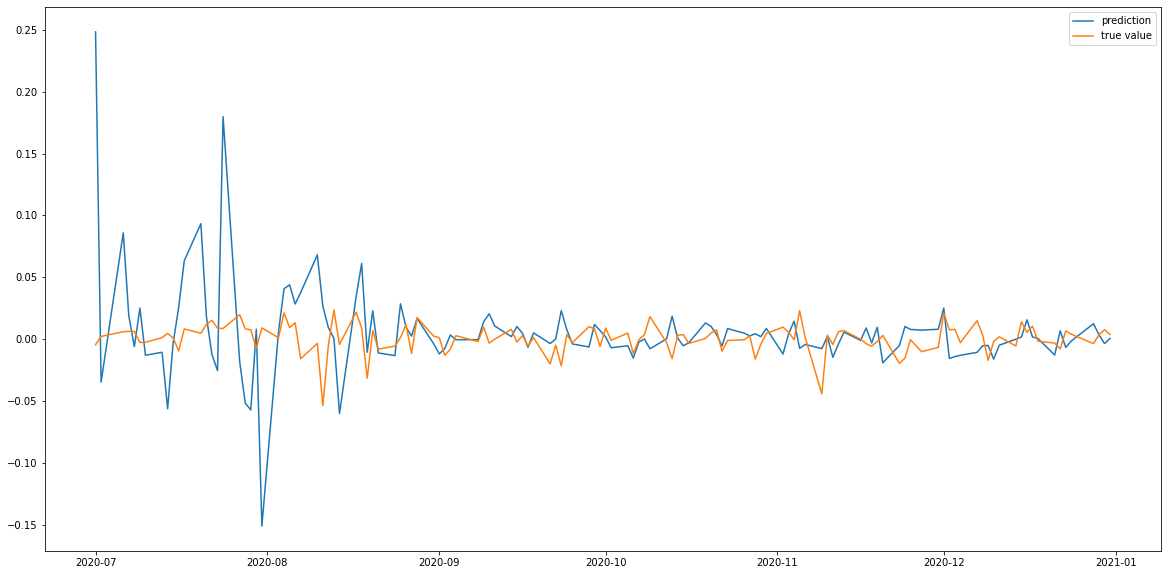

In [380]:
plt.plot(data_q3_q4['GLD_pp_v3'], label = 'prediction')
plt.plot(data_q3_q4['GLD_dr'], label = 'true value')
plt.legend()

In [315]:
data_q3_q4['EEM_pp_v'] = [VAR_fit_predict(data[['GBTC_dr', 'EEM', 'GLD_dr']].iloc[0:i-1], data_q2[['GBTC_dr', 'GLD_dr']])[1] for i in range(len(data_q2) -1, len(data))]

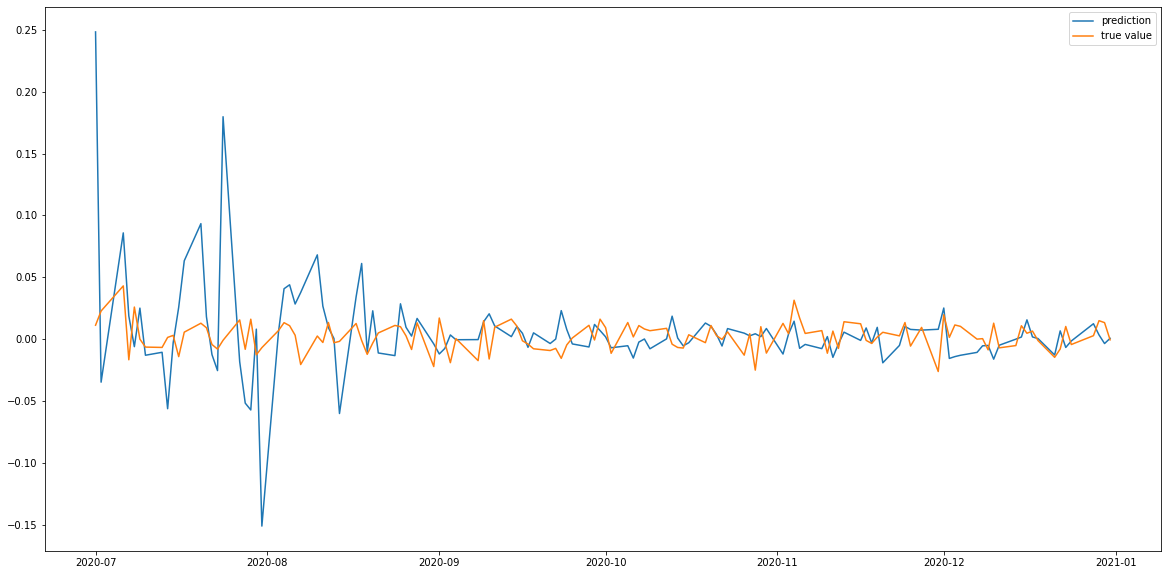

In [325]:
plt.plot(data_q3_q4['EEM_pp_v'], label = 'prediction')
plt.plot(data_q3_q4['EEM_dr'], label = 'true value')
plt.legend()

In [381]:
data_q3_q4['GBTC_pp_v3'] = [VAR_fit_predict(data[['GBTC_dr', 'EEM', 'GLD_dr']].iloc[0:i-1], data_q2[['GBTC_dr', 'GLD_dr']])[0] for i in range(len(data_q2) -1, len(data))]

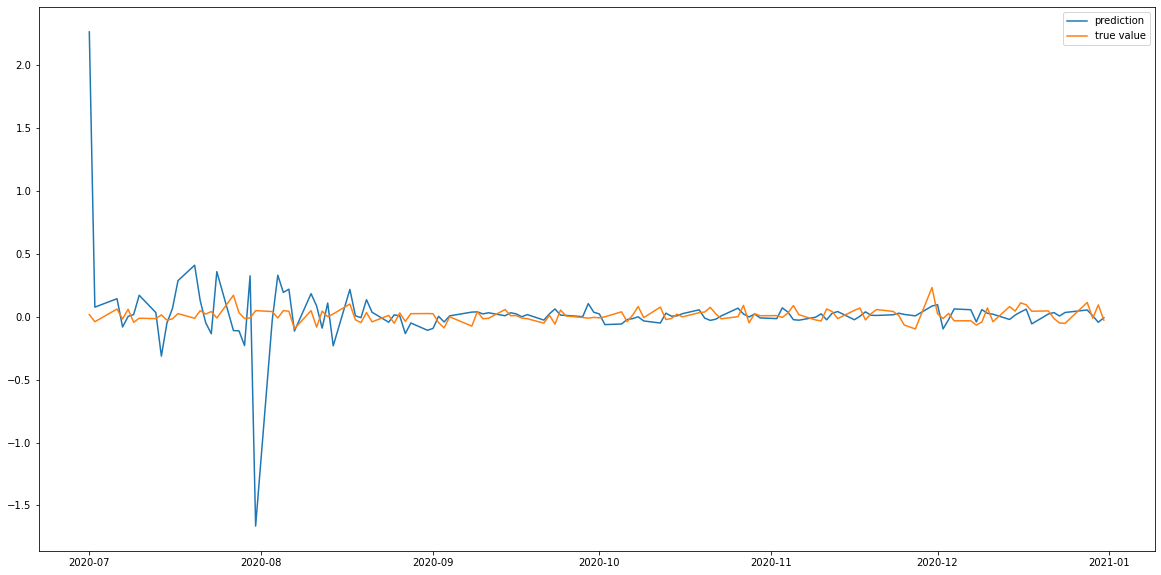

In [382]:
plt.plot(data_q3_q4['GBTC_pp_v3'], label = 'prediction')
plt.plot(data_q3_q4['GBTC_dr'], label = 'true value')
plt.legend()

In [333]:
def po_allocation(GLD_return, EEM_return, GBTC_return):
    gld = abs(GLD_return)/(abs(GLD_return)+abs(GBTC_return)+abs(EEM_return))
    gbtc = abs(GBTC_return)/(abs(GLD_return)+abs(GBTC_return)+abs(EEM_return))
    eem = abs(EEM_return)/(abs(GLD_return)+abs(GBTC_return)+abs(EEM_return))
    return gld*abs(GLD_return)/GLD_return, gbtc*abs(GBTC_return)/GBTC_return, eem*abs(EEM_return)/EEM_return

In [339]:
class VAR3_GLD(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(po_allocation(data_q3_q4['GLD_pp_v'], data_q3_q4['GBTC_pp_v'], data_q3_q4['EEM_pp_v'])[0]*100)
bt = Backtest(GLD[Jul20:Jan21], VAR3_GLD, exclusive_orders=False)
stats = bt.run()
bt.plot()

Row(id='20229', ...)

In [340]:
stats

Start                     2020-07-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    183 days 00:00:00
Exposure Time [%]                     98.4375
Equity Final [$]                  9976.849838
Equity Peak [$]                  10178.650024
Return [%]                          -0.231502
Buy & Hold Return [%]                7.045976
Return (Ann.) [%]                   -0.455258
Volatility (Ann.) [%]                7.397207
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -4.319892
Avg. Drawdown [%]                   -1.930891
Max. Drawdown Duration       69 days 00:00:00
Avg. Drawdown Duration       44 days 00:00:00
# Trades                                   35
Win Rate [%]                             40.0
Best Trade [%]                        7.82491
Worst Trade [%]                    -14.220028
Avg. Trade [%]                    

In [342]:
class VAR3_BTC(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(po_allocation(data_q3_q4['GLD_pp_v'], data_q3_q4['GBTC_pp_v'], data_q3_q4['EEM_pp_v'])[1])
bt = Backtest(GBTC[Jul20:Jan21], VAR3_BTC, exclusive_orders=False)
stats = bt.run()
bt.plot()

Row(id='21025', ...)

In [343]:
stats

Start                     2020-07-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    183 days 00:00:00
Exposure Time [%]                     98.4375
Equity Final [$]                 33154.160398
Equity Peak [$]                  34086.321977
Return [%]                         231.541604
Buy & Hold Return [%]              227.868845
Return (Ann.) [%]                  958.788596
Volatility (Ann.) [%]              996.905553
Sharpe Ratio                         0.961765
Sortino Ratio                       22.660978
Calmar Ratio                        34.164029
Max. Drawdown [%]                  -28.064272
Avg. Drawdown [%]                   -7.810482
Max. Drawdown Duration       71 days 00:00:00
Avg. Drawdown Duration       11 days 00:00:00
# Trades                                    3
Win Rate [%]                            100.0
Best Trade [%]                     234.093295
Worst Trade [%]                      1.658039
Avg. Trade [%]                    

In [344]:
class VAR3_EEM(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(po_allocation(data_q3_q4['GLD_pp_v'], data_q3_q4['GBTC_pp_v'], data_q3_q4['EEM_pp_v'])[2])
bt = Backtest(EEM[Jul20:Jan21], VAR3_EEM, exclusive_orders=False)
stats = bt.run()
bt.plot()

Row(id='21822', ...)

In [345]:
stats

Start                     2020-07-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    183 days 00:00:00
Exposure Time [%]                    92.96875
Equity Final [$]                  9894.319988
Equity Peak [$]                   10003.39999
Return [%]                            -1.0568
Buy & Hold Return [%]               27.769535
Return (Ann.) [%]                   -2.069924
Volatility (Ann.) [%]                0.860455
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.090429
Avg. Drawdown [%]                   -0.689807
Max. Drawdown Duration       98 days 00:00:00
Avg. Drawdown Duration       84 days 00:00:00
# Trades                                    6
Win Rate [%]                              0.0
Best Trade [%]                      -0.825122
Worst Trade [%]                    -19.654777
Avg. Trade [%]                    

We note here that in a 3 universe assets, given our simple formula based on expected return to construct portfolio weight, the model is discouraged from making more trades given the smaller expected return. The result in this section are thus subjected to higher variance as the models made significantly less trades. A further study with better portfolio optimization is needed to better evaluate the effectiveness of this method

#### 2nd type: Co-integration based

Since we already know GLD and GBTC contains no trend component from the previous section, we only need to conduct trend/ unit root test on EEM data

In [346]:
trend_test(data['EEM'])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0803      0.002     41.826      0.000       0.076       0.084

In [360]:
ADF(data['EEM'], trend = "n")

Test Statistic,-6.964
P-value,0.000
Lags,3


Since EEM also contain unit root, we now conduct 6 pairwise test to find cointegration

In [365]:
eg_test(data['GLD'],data['GBTC'])

the t-statistic is: -1.7848659962053857, the p-value is: 0.6370436952986417, and the critical value at 5% test statistic is -3.3720949157005573


In [366]:
eg_test(data['GLD'],data['EEM'])

the t-statistic is: -1.8140156137114722, the p-value is: 0.6228895511269028, and the critical value at 5% test statistic is -3.3720949157005573


In [367]:
eg_test(data['EEM'],data['GBTC'])

the t-statistic is: -1.8502897833455862, the p-value is: 0.6049888934816657, and the critical value at 5% test statistic is -3.3720949157005573


In [368]:
eg_test(data['EEM'],data['GLD'])

the t-statistic is: -0.7457399056110068, the p-value is: 0.9414707204593907, and the critical value at 5% test statistic is -3.3720949157005573


In [369]:
eg_test(data['GBTC'],data['GLD'])

the t-statistic is: 1.5679397586221997, the p-value is: 1.0, and the critical value at 5% test statistic is -3.3720949157005573


In [370]:
eg_test(data['GBTC'],data['EEM'])

the t-statistic is: -0.7152095603778567, the p-value is: 0.9449722465944543, and the critical value at 5% test statistic is -3.3720949157005573


All 6 tests reveals no cointegration. Thus we skip pair trading strategy and VECM

### Step 8: Combining the models

Statistically, the best performing model by a large margin were VAR based with GLD, EEM, and GBTC. However, this could also be attributed to the fact that in this work, we did not have time to do proper portfolio optimization, which lead to small trading sample size. The next well performed model were 2 variables GARCH and 1 variable GARCH, then VAR-based and ARMA is the worst performing model

We derive a simple model, using combined average predictions from all 5 models prediction (3 were not implemented in the absence of cointegration relationship) and evalute it's performance in Q3 Q4 data as follow

In [386]:
s = (data_q3_q4['GBTC_pp_g'] + data_q3_q4['GBTC_pp_g'] + data_q3_q4['GBTC_pp_a'] + data_q3_q4['GBTC_pp_v3'] + data_q3_q4['GBTC_pp_v'])/5

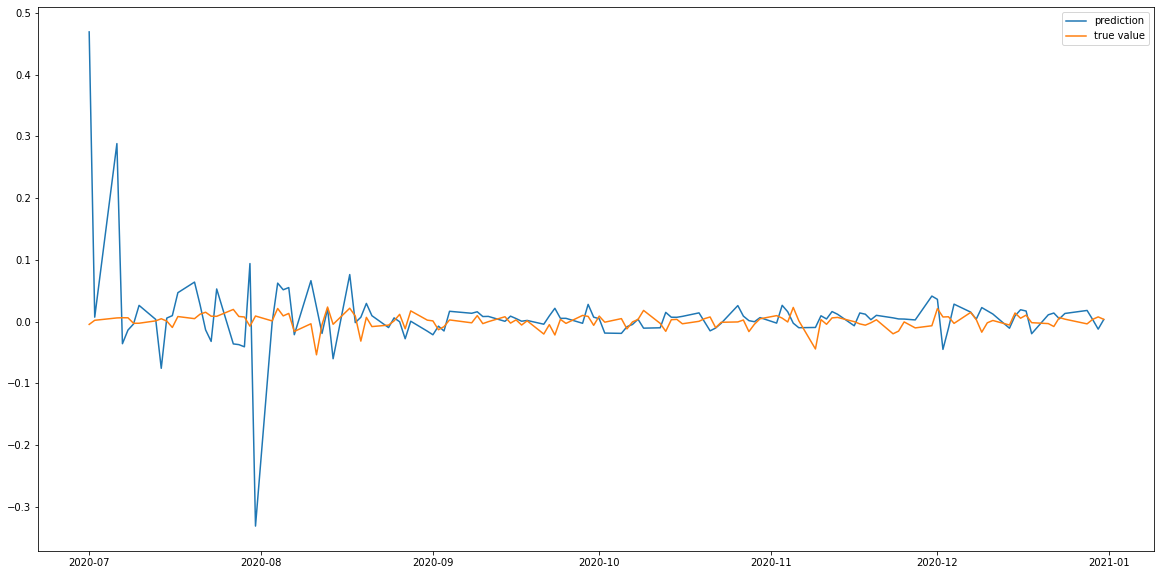

In [391]:
plt.plot(s, label = 'prediction')
plt.plot(data_q3_q4['GLD_dr'], label = 'true value')
plt.legend()

In [389]:
class W(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(s)
bt = Backtest(GBTC[Jul20:Jan21], W, exclusive_orders=False)
stats = bt.run()
bt.plot()

Row(id='25008', ...)

In [390]:
stats

Start                     2020-07-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    183 days 00:00:00
Exposure Time [%]                     98.4375
Equity Final [$]                 18877.060619
Equity Peak [$]                  19166.380554
Return [%]                          88.770606
Buy & Hold Return [%]              227.868845
Return (Ann.) [%]                   249.33797
Volatility (Ann.) [%]              149.758244
Sharpe Ratio                         1.664937
Sortino Ratio                       12.252838
Calmar Ratio                        21.641398
Max. Drawdown [%]                  -11.521343
Avg. Drawdown [%]                   -3.651639
Max. Drawdown Duration       65 days 00:00:00
Avg. Drawdown Duration       10 days 00:00:00
# Trades                                  110
Win Rate [%]                             90.0
Best Trade [%]                     205.014216
Worst Trade [%]                    -10.551942
Avg. Trade [%]                    

The combined model performs very well, with higher return percentage than most models, with more trades to reduce variance